# 적대적 생성 신경망 실습

### 랜덤 시드 설정

In [1]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

### 데이터 불러오기

In [2]:
from tensorflow.keras.datasets import mnist
(X_raw, _), (_, _) = mnist.load_data()

### 학습을 위한 변수 설정

In [3]:
n_img = X_raw.shape[0]
print(n_img)
epoch = 3000
n_batch = 100

60000


### 데이터 전처리

In [4]:
import numpy as np
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

### 딥러닝 라이브러리 불러오기

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU

### 생성자 모형 생성

In [7]:
input_layer1 = Input(shape=(100, ))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7, 7, 64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3, 3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3, 3),
                      padding='same',
                      activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                           

In [8]:
### 판별자 모형 생성

In [10]:
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5, 5),
           padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3, 3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy',
                     optimizer = 'adam',
                     metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 activation_3 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0   

### GAN 모형 생성

In [11]:
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy',
           optimizer='adam',
           metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         348161    
                                                                 
 model_1 (Functional)        (None, 1)                 175873    
                                                                 
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


### 학습

In [13]:
loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)         # 0과 n_img 사이 숫자 중 n_batch 개 정수선택
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))     # 평균 0, 표준 편차 1 인 분포에서 size 개수만큼 랜덤 데이터 생성
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0], res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1], res_fake[1])*0.5
    
    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)
    
    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    
    acc_disc_real[i] = res_real[1]      # 실제 데이터와 타깃 데이터 1을 이용해 판별할 때의 정확도
    acc_disc_fake[i] = res_fake[1]      # 가짜 데이터와 타깃 데이터 0을 이용해 판별할 때의 정확도
    acc_disc_avg[i] = acc_disc_avg_ith  # 둘의 평균
    acc_gan[i] = res_gan[1]             # GAN 모형의 정확도
    
    print('epoch:%d' %i,
         '판별손실평균:%.4f'%loss_disc_avg_ith,
         '판별정확도평균:%.4f'%acc_disc_avg_ith,
         '생성손실:%.4f'%res_gan[0],
         '생성정확도:%.4f'%res_gan[1])

epoch:0 판별손실평균:0.5892 판별정확도평균:0.5000 생성손실:0.2958 생성정확도:1.0000
epoch:1 판별손실평균:0.2544 판별정확도평균:1.0000 생성손실:2.9412 생성정확도:0.0000
epoch:2 판별손실평균:1.1861 판별정확도평균:0.5000 생성손실:0.1888 생성정확도:1.0000
epoch:3 판별손실평균:0.1941 판별정확도평균:1.0000 생성손실:0.0076 생성정확도:1.0000
epoch:4 판별손실평균:0.1249 판별정확도평균:0.9950 생성손실:0.0002 생성정확도:1.0000
epoch:5 판별손실평균:0.0641 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:6 판별손실평균:0.0235 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:7 판별손실평균:0.0094 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:8 판별손실평균:0.0022 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:9 판별손실평균:0.0010 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:10 판별손실평균:0.0005 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:11 판별손실평균:0.0002 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:12 판별손실평균:0.0018 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:13 판별손실평균:0.0004 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:14 판별손실평균:0.0003 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
epoch:15 판별손실평균:0.0010 판별정확도평균:1.0000 생성손실:0.0000 생성정확도:1.0000
ep

epoch:130 판별손실평균:0.3062 판별정확도평균:0.8600 생성손실:0.5084 생성정확도:0.7700
epoch:131 판별손실평균:0.2875 판별정확도평균:0.8950 생성손실:0.6722 생성정확도:0.6400
epoch:132 판별손실평균:0.3233 판별정확도평균:0.8700 생성손실:0.5517 생성정확도:0.7400
epoch:133 판별손실평균:0.1847 판별정확도평균:0.9400 생성손실:0.7268 생성정확도:0.6700
epoch:134 판별손실평균:0.2458 판별정확도평균:0.9000 생성손실:0.8504 생성정확도:0.5600
epoch:135 판별손실평균:0.2521 판별정확도평균:0.8900 생성손실:0.8867 생성정확도:0.5500
epoch:136 판별손실평균:0.2482 판별정확도평균:0.9150 생성손실:1.2105 생성정확도:0.4000
epoch:137 판별손실평균:0.2013 판별정확도평균:0.9200 생성손실:1.6404 생성정확도:0.2000
epoch:138 판별손실평균:0.1912 판별정확도평균:0.9350 생성손실:2.0573 생성정확도:0.1300
epoch:139 판별손실평균:0.2585 판별정확도평균:0.9000 생성손실:2.3212 생성정확도:0.0600
epoch:140 판별손실평균:0.2705 판별정확도평균:0.8800 생성손실:2.6905 생성정확도:0.0600
epoch:141 판별손실평균:0.2544 판별정확도평균:0.9000 생성손실:3.1775 생성정확도:0.0200
epoch:142 판별손실평균:0.1664 판별정확도평균:0.9400 생성손실:3.9728 생성정확도:0.0200
epoch:143 판별손실평균:0.1837 판별정확도평균:0.9350 생성손실:4.2856 생성정확도:0.0200
epoch:144 판별손실평균:0.0985 판별정확도평균:0.9750 생성손실:3.9274 생성정확도:0.0400
epoch:145 판별손실평균:0.0784 판별정확도평균:0.9750 생

epoch:259 판별손실평균:0.4786 판별정확도평균:0.7550 생성손실:1.3107 생성정확도:0.3200
epoch:260 판별손실평균:0.4049 판별정확도평균:0.8200 생성손실:1.5353 생성정확도:0.1500
epoch:261 판별손실평균:0.4101 판별정확도평균:0.8200 생성손실:1.7984 생성정확도:0.1700
epoch:262 판별손실평균:0.4130 판별정확도평균:0.8350 생성손실:1.6414 생성정확도:0.2500
epoch:263 판별손실평균:0.4058 판별정확도평균:0.7950 생성손실:1.9830 생성정확도:0.1500
epoch:264 판별손실평균:0.4518 판별정확도평균:0.7900 생성손실:1.9836 생성정확도:0.1700
epoch:265 판별손실평균:0.3964 판별정확도평균:0.8250 생성손실:1.8638 생성정확도:0.1500
epoch:266 판별손실평균:0.4322 판별정확도평균:0.7900 생성손실:2.2024 생성정확도:0.1000
epoch:267 판별손실평균:0.3729 판별정확도평균:0.8400 생성손실:2.6630 생성정확도:0.0500
epoch:268 판별손실평균:0.4545 판별정확도평균:0.7850 생성손실:2.4340 생성정확도:0.0400
epoch:269 판별손실평균:0.4565 판별정확도평균:0.7550 생성손실:2.2823 생성정확도:0.1400
epoch:270 판별손실평균:0.4552 판별정확도평균:0.7900 생성손실:2.3147 생성정확도:0.1200
epoch:271 판별손실평균:0.4129 판별정확도평균:0.7800 생성손실:2.9774 생성정확도:0.0800
epoch:272 판별손실평균:0.5210 판별정확도평균:0.7300 생성손실:2.8105 생성정확도:0.0800
epoch:273 판별손실평균:0.4498 판별정확도평균:0.7850 생성손실:2.8114 생성정확도:0.0500
epoch:274 판별손실평균:0.4410 판별정확도평균:0.7950 생

epoch:388 판별손실평균:0.3353 판별정확도평균:0.8550 생성손실:2.2275 생성정확도:0.1400
epoch:389 판별손실평균:0.4248 판별정확도평균:0.7950 생성손실:2.0713 생성정확도:0.1400
epoch:390 판별손실평균:0.2897 판별정확도평균:0.8950 생성손실:2.2317 생성정확도:0.1000
epoch:391 판별손실평균:0.3106 판별정확도평균:0.8850 생성손실:2.2224 생성정확도:0.0500
epoch:392 판별손실평균:0.3352 판별정확도평균:0.8600 생성손실:2.1170 생성정확도:0.1200
epoch:393 판별손실평균:0.2932 판별정확도평균:0.8850 생성손실:2.1156 생성정확도:0.0800
epoch:394 판별손실평균:0.3072 판별정확도평균:0.8900 생성손실:2.0715 생성정확도:0.0700
epoch:395 판별손실평균:0.3017 판별정확도평균:0.8750 생성손실:2.2545 생성정확도:0.0900
epoch:396 판별손실평균:0.3191 판별정확도평균:0.8650 생성손실:2.3499 생성정확도:0.0600
epoch:397 판별손실평균:0.2300 판별정확도평균:0.9300 생성손실:2.5898 생성정확도:0.0200
epoch:398 판별손실평균:0.2908 판별정확도평균:0.8800 생성손실:2.3817 생성정확도:0.0800
epoch:399 판별손실평균:0.3095 판별정확도평균:0.8800 생성손실:2.0673 생성정확도:0.1200
epoch:400 판별손실평균:0.2443 판별정확도평균:0.9150 생성손실:2.2298 생성정확도:0.0700
epoch:401 판별손실평균:0.2640 판별정확도평균:0.8950 생성손실:2.5230 생성정확도:0.0600
epoch:402 판별손실평균:0.2516 판별정확도평균:0.9100 생성손실:2.7170 생성정확도:0.0500
epoch:403 판별손실평균:0.2659 판별정확도평균:0.9050 생

epoch:517 판별손실평균:0.5240 판별정확도평균:0.7450 생성손실:1.5706 생성정확도:0.2200
epoch:518 판별손실평균:0.3986 판별정확도평균:0.8250 생성손실:2.2200 생성정확도:0.0700
epoch:519 판별손실평균:0.4470 판별정확도평균:0.8000 생성손실:2.4513 생성정확도:0.0300
epoch:520 판별손실평균:0.4465 판별정확도평균:0.7800 생성손실:2.1973 생성정확도:0.0700
epoch:521 판별손실평균:0.4540 판별정확도평균:0.8250 생성손실:2.1147 생성정확도:0.1200
epoch:522 판별손실평균:0.3866 판별정확도평균:0.8650 생성손실:2.2163 생성정확도:0.0500
epoch:523 판별손실평균:0.4806 판별정확도평균:0.7900 생성손실:2.2172 생성정확도:0.0700
epoch:524 판별손실평균:0.3276 판별정확도평균:0.8900 생성손실:2.4691 생성정확도:0.0200
epoch:525 판별손실평균:0.4828 판별정확도평균:0.8100 생성손실:2.2802 생성정확도:0.0500
epoch:526 판별손실평균:0.3655 판별정확도평균:0.8400 생성손실:2.1487 생성정확도:0.1000
epoch:527 판별손실평균:0.3760 판별정확도평균:0.7800 생성손실:2.0223 생성정확도:0.0900
epoch:528 판별손실평균:0.3867 판별정확도평균:0.8650 생성손실:2.2771 생성정확도:0.0600
epoch:529 판별손실평균:0.3220 판별정확도평균:0.8700 생성손실:2.3041 생성정확도:0.0400
epoch:530 판별손실평균:0.2979 판별정확도평균:0.8800 생성손실:2.2675 생성정확도:0.1000
epoch:531 판별손실평균:0.2849 판별정확도평균:0.8850 생성손실:2.1879 생성정확도:0.1000
epoch:532 판별손실평균:0.3391 판별정확도평균:0.8500 생

epoch:646 판별손실평균:0.2295 판별정확도평균:0.9250 생성손실:3.0304 생성정확도:0.0500
epoch:647 판별손실평균:0.2531 판별정확도평균:0.8950 생성손실:3.1124 생성정확도:0.0400
epoch:648 판별손실평균:0.3060 판별정확도평균:0.8900 생성손실:2.4901 생성정확도:0.0900
epoch:649 판별손실평균:0.2910 판별정확도평균:0.8700 생성손실:2.0382 생성정확도:0.1400
epoch:650 판별손실평균:0.3756 판별정확도평균:0.8250 생성손실:2.3754 생성정확도:0.0900
epoch:651 판별손실평균:0.2529 판별정확도평균:0.8950 생성손실:3.0551 생성정확도:0.0300
epoch:652 판별손실평균:0.2158 판별정확도평균:0.9250 생성손실:3.3550 생성정확도:0.0100
epoch:653 판별손실평균:0.4603 판별정확도평균:0.8450 생성손실:2.3576 생성정확도:0.1600
epoch:654 판별손실평균:0.3005 판별정확도평균:0.8650 생성손실:2.0678 생성정확도:0.1100
epoch:655 판별손실평균:0.3224 판별정확도평균:0.8800 생성손실:2.9257 생성정확도:0.0400
epoch:656 판별손실평균:0.2443 판별정확도평균:0.9050 생성손실:3.5135 생성정확도:0.0100
epoch:657 판별손실평균:0.4235 판별정확도평균:0.8100 생성손실:2.4182 생성정확도:0.0500
epoch:658 판별손실평균:0.3630 판별정확도평균:0.8450 생성손실:2.0599 생성정확도:0.1400
epoch:659 판별손실평균:0.2806 판별정확도평균:0.8800 생성손실:2.4769 생성정확도:0.0200
epoch:660 판별손실평균:0.2606 판별정확도평균:0.9100 생성손실:2.9619 생성정확도:0.0100
epoch:661 판별손실평균:0.3385 판별정확도평균:0.8650 생

epoch:775 판별손실평균:0.1994 판별정확도평균:0.9400 생성손실:3.5791 생성정확도:0.0200
epoch:776 판별손실평균:0.2661 판별정확도평균:0.8900 생성손실:3.1520 생성정확도:0.0600
epoch:777 판별손실평균:0.2331 판별정확도평균:0.9250 생성손실:2.6880 생성정확도:0.0800
epoch:778 판별손실평균:0.1785 판별정확도평균:0.9450 생성손실:3.0538 생성정확도:0.0500
epoch:779 판별손실평균:0.2439 판별정확도평균:0.9000 생성손실:2.9697 생성정확도:0.0400
epoch:780 판별손실평균:0.2601 판별정확도평균:0.8950 생성손실:2.8486 생성정확도:0.0500
epoch:781 판별손실평균:0.1981 판별정확도평균:0.9100 생성손실:3.1608 생성정확도:0.0400
epoch:782 판별손실평균:0.2249 판별정확도평균:0.9250 생성손실:2.9854 생성정확도:0.0600
epoch:783 판별손실평균:0.2408 판별정확도평균:0.8900 생성손실:2.7193 생성정확도:0.1000
epoch:784 판별손실평균:0.2674 판별정확도평균:0.8650 생성손실:2.4801 생성정확도:0.0600
epoch:785 판별손실평균:0.2467 판별정확도평균:0.9000 생성손실:3.0415 생성정확도:0.0600
epoch:786 판별손실평균:0.3485 판별정확도평균:0.8150 생성손실:2.8795 생성정확도:0.0600
epoch:787 판별손실평균:0.2261 판별정확도평균:0.9300 생성손실:2.4190 생성정확도:0.0900
epoch:788 판별손실평균:0.3626 판별정확도평균:0.8200 생성손실:2.2605 생성정확도:0.1200
epoch:789 판별손실평균:0.3332 판별정확도평균:0.8500 생성손실:2.5485 생성정확도:0.0600
epoch:790 판별손실평균:0.2652 판별정확도평균:0.8800 생

epoch:904 판별손실평균:0.3570 판별정확도평균:0.8100 생성손실:1.9002 생성정확도:0.2100
epoch:905 판별손실평균:0.4103 판별정확도평균:0.8200 생성손실:2.4603 생성정확도:0.1200
epoch:906 판별손실평균:0.2768 판별정확도평균:0.8900 생성손실:3.3475 생성정확도:0.0500
epoch:907 판별손실평균:0.3340 판별정확도평균:0.8700 생성손실:2.7789 생성정확도:0.0900
epoch:908 판별손실평균:0.4293 판별정확도평균:0.8300 생성손실:1.7158 생성정확도:0.2000
epoch:909 판별손실평균:0.4118 판별정확도평균:0.7950 생성손실:2.6478 생성정확도:0.0400
epoch:910 판별손실평균:0.3008 판별정확도평균:0.8750 생성손실:3.7300 생성정확도:0.0300
epoch:911 판별손실평균:0.3710 판별정확도평균:0.8300 생성손실:3.2561 생성정확도:0.0700
epoch:912 판별손실평균:0.4289 판별정확도평균:0.7850 생성손실:2.4346 생성정확도:0.1000
epoch:913 판별손실평균:0.3634 판별정확도평균:0.8050 생성손실:2.4745 생성정확도:0.1200
epoch:914 판별손실평균:0.2801 판별정확도평균:0.8750 생성손실:3.2396 생성정확도:0.0400
epoch:915 판별손실평균:0.3949 판별정확도평균:0.8250 생성손실:2.8340 생성정확도:0.0300
epoch:916 판별손실평균:0.3932 판별정확도평균:0.8500 생성손실:2.5882 생성정확도:0.1300
epoch:917 판별손실평균:0.4197 판별정확도평균:0.8000 생성손실:2.4775 생성정확도:0.0800
epoch:918 판별손실평균:0.3580 판별정확도평균:0.8550 생성손실:3.0069 생성정확도:0.1000
epoch:919 판별손실평균:0.3686 판별정확도평균:0.8350 생

epoch:1032 판별손실평균:0.3456 판별정확도평균:0.8800 생성손실:2.3094 생성정확도:0.0800
epoch:1033 판별손실평균:0.5360 판별정확도평균:0.7650 생성손실:1.5342 생성정확도:0.2300
epoch:1034 판별손실평균:0.4069 판별정확도평균:0.8250 생성손실:1.6236 생성정확도:0.1600
epoch:1035 판별손실평균:0.3302 판별정확도평균:0.8500 생성손실:2.5750 생성정확도:0.0200
epoch:1036 판별손실평균:0.3803 판별정확도평균:0.8000 생성손실:3.2256 생성정확도:0.0200
epoch:1037 판별손실평균:0.5707 판별정확도평균:0.7050 생성손실:2.1686 생성정확도:0.1000
epoch:1038 판별손실평균:0.4723 판별정확도평균:0.7850 생성손실:2.1336 생성정확도:0.1000
epoch:1039 판별손실평균:0.3475 판별정확도평균:0.8400 생성손실:2.5888 생성정확도:0.0400
epoch:1040 판별손실평균:0.3408 판별정확도평균:0.8500 생성손실:2.3324 생성정확도:0.0900
epoch:1041 판별손실평균:0.4377 판별정확도평균:0.7950 생성손실:2.3148 생성정확도:0.0400
epoch:1042 판별손실평균:0.3807 판별정확도평균:0.8150 생성손실:3.2437 생성정확도:0.0200
epoch:1043 판별손실평균:0.4500 판별정확도평균:0.8050 생성손실:3.3857 생성정확도:0.0200
epoch:1044 판별손실평균:0.4339 판별정확도평균:0.7700 생성손실:2.9053 생성정확도:0.0400
epoch:1045 판별손실평균:0.2914 판별정확도평균:0.8750 생성손실:3.0413 생성정확도:0.0100
epoch:1046 판별손실평균:0.3802 판별정확도평균:0.8150 생성손실:2.8122 생성정확도:0.0400
epoch:1047 판별손실평균:0.3949 

epoch:1159 판별손실평균:0.3587 판별정확도평균:0.8650 생성손실:2.2133 생성정확도:0.0800
epoch:1160 판별손실평균:0.3672 판별정확도평균:0.8500 생성손실:2.5212 생성정확도:0.0200
epoch:1161 판별손실평균:0.4381 판별정확도평균:0.7900 생성손실:1.9636 생성정확도:0.1300
epoch:1162 판별손실평균:0.5156 판별정확도평균:0.7550 생성손실:1.6391 생성정확도:0.2100
epoch:1163 판별손실평균:0.4699 판별정확도평균:0.7750 생성손실:1.9224 생성정확도:0.1800
epoch:1164 판별손실평균:0.3438 판별정확도평균:0.8550 생성손실:2.4164 생성정확도:0.0400
epoch:1165 판별손실평균:0.4865 판별정확도평균:0.7750 생성손실:1.9698 생성정확도:0.1000
epoch:1166 판별손실평균:0.3693 판별정확도평균:0.8400 생성손실:1.7889 생성정확도:0.1200
epoch:1167 판별손실평균:0.3981 판별정확도평균:0.8150 생성손실:1.6478 생성정확도:0.1600
epoch:1168 판별손실평균:0.4880 판별정확도평균:0.7850 생성손실:1.9096 생성정확도:0.1100
epoch:1169 판별손실평균:0.4328 판별정확도평균:0.8150 생성손실:2.3755 생성정확도:0.0100
epoch:1170 판별손실평균:0.5144 판별정확도평균:0.7750 생성손실:2.0432 생성정확도:0.0500
epoch:1171 판별손실평균:0.4527 판별정확도평균:0.7800 생성손실:1.8726 생성정확도:0.0900
epoch:1172 판별손실평균:0.4332 판별정확도평균:0.8000 생성손실:2.1624 생성정확도:0.0700
epoch:1173 판별손실평균:0.4068 판별정확도평균:0.8350 생성손실:2.2500 생성정확도:0.0900
epoch:1174 판별손실평균:0.4799 

epoch:1286 판별손실평균:0.5401 판별정확도평균:0.7400 생성손실:1.7442 생성정확도:0.0900
epoch:1287 판별손실평균:0.3492 판별정확도평균:0.8650 생성손실:1.9177 생성정확도:0.0800
epoch:1288 판별손실평균:0.5387 판별정확도평균:0.7350 생성손실:2.1914 생성정확도:0.0800
epoch:1289 판별손실평균:0.4988 판별정확도평균:0.7650 생성손실:2.0030 생성정확도:0.1000
epoch:1290 판별손실평균:0.4563 판별정확도평균:0.7700 생성손실:1.8882 생성정확도:0.1400
epoch:1291 판별손실평균:0.4684 판별정확도평균:0.7550 생성손실:1.7198 생성정확도:0.1100
epoch:1292 판별손실평균:0.4290 판별정확도평균:0.8250 생성손실:2.0269 생성정확도:0.1000
epoch:1293 판별손실평균:0.5143 판별정확도평균:0.7300 생성손실:1.8970 생성정확도:0.1000
epoch:1294 판별손실평균:0.5048 판별정확도평균:0.7150 생성손실:1.9120 생성정확도:0.1300
epoch:1295 판별손실평균:0.4456 판별정확도평균:0.7950 생성손실:1.9547 생성정확도:0.1600
epoch:1296 판별손실평균:0.4564 판별정확도평균:0.7800 생성손실:2.0815 생성정확도:0.1600
epoch:1297 판별손실평균:0.5242 판별정확도평균:0.7800 생성손실:1.8957 생성정확도:0.1300
epoch:1298 판별손실평균:0.3905 판별정확도평균:0.8200 생성손실:2.1443 생성정확도:0.1100
epoch:1299 판별손실평균:0.4505 판별정확도평균:0.7850 생성손실:1.9207 생성정확도:0.1300
epoch:1300 판별손실평균:0.5049 판별정확도평균:0.7150 생성손실:1.9928 생성정확도:0.0800
epoch:1301 판별손실평균:0.4302 

epoch:1413 판별손실평균:0.3978 판별정확도평균:0.8100 생성손실:2.0755 생성정확도:0.0900
epoch:1414 판별손실평균:0.4135 판별정확도평균:0.8300 생성손실:1.9154 생성정확도:0.0900
epoch:1415 판별손실평균:0.5879 판별정확도평균:0.7100 생성손실:1.7566 생성정확도:0.1500
epoch:1416 판별손실평균:0.3989 판별정확도평균:0.8200 생성손실:2.3671 생성정확도:0.0600
epoch:1417 판별손실평균:0.4259 판별정확도평균:0.8350 생성손실:2.3999 생성정확도:0.0600
epoch:1418 판별손실평균:0.4891 판별정확도평균:0.7900 생성손실:1.8199 생성정확도:0.1600
epoch:1419 판별손실평균:0.4809 판별정확도평균:0.7550 생성손실:2.2332 생성정확도:0.0700
epoch:1420 판별손실평균:0.4642 판별정확도평균:0.7550 생성손실:2.3206 생성정확도:0.1100
epoch:1421 판별손실평균:0.4583 판별정확도평균:0.7900 생성손실:2.2263 생성정확도:0.1200
epoch:1422 판별손실평균:0.5076 판별정확도평균:0.7550 생성손실:1.8310 생성정확도:0.0900
epoch:1423 판별손실평균:0.4996 판별정확도평균:0.7600 생성손실:1.8870 생성정확도:0.1800
epoch:1424 판별손실평균:0.4923 판별정확도평균:0.7950 생성손실:1.9354 생성정확도:0.1200
epoch:1425 판별손실평균:0.4489 판별정확도평균:0.7800 생성손실:2.0748 생성정확도:0.0800
epoch:1426 판별손실평균:0.4388 판별정확도평균:0.8100 생성손실:1.7165 생성정확도:0.1700
epoch:1427 판별손실평균:0.4790 판별정확도평균:0.7650 생성손실:1.7294 생성정확도:0.1300
epoch:1428 판별손실평균:0.4057 

epoch:1540 판별손실평균:0.4136 판별정확도평균:0.8050 생성손실:1.9640 생성정확도:0.1100
epoch:1541 판별손실평균:0.4291 판별정확도평균:0.8050 생성손실:2.0740 생성정확도:0.1100
epoch:1542 판별손실평균:0.3886 판별정확도평균:0.8450 생성손실:2.2340 생성정확도:0.0700
epoch:1543 판별손실평균:0.4705 판별정확도평균:0.7350 생성손실:2.0070 생성정확도:0.1100
epoch:1544 판별손실평균:0.4405 판별정확도평균:0.8000 생성손실:1.9820 생성정확도:0.0800
epoch:1545 판별손실평균:0.4811 판별정확도평균:0.7550 생성손실:1.7041 생성정확도:0.1500
epoch:1546 판별손실평균:0.4178 판별정확도평균:0.8200 생성손실:2.1489 생성정확도:0.0900
epoch:1547 판별손실평균:0.3892 판별정확도평균:0.7950 생성손실:2.1307 생성정확도:0.0400
epoch:1548 판별손실평균:0.4523 판별정확도평균:0.8200 생성손실:2.0752 생성정확도:0.0700
epoch:1549 판별손실평균:0.4913 판별정확도평균:0.7350 생성손실:1.9551 생성정확도:0.1400
epoch:1550 판별손실평균:0.4305 판별정확도평균:0.7950 생성손실:2.0216 생성정확도:0.1600
epoch:1551 판별손실평균:0.3416 판별정확도평균:0.8850 생성손실:2.3306 생성정확도:0.0500
epoch:1552 판별손실평균:0.4603 판별정확도평균:0.8300 생성손실:2.0623 생성정확도:0.1100
epoch:1553 판별손실평균:0.4545 판별정확도평균:0.7700 생성손실:1.9059 생성정확도:0.0900
epoch:1554 판별손실평균:0.4803 판별정확도평균:0.7500 생성손실:1.8865 생성정확도:0.1400
epoch:1555 판별손실평균:0.4174 

epoch:1667 판별손실평균:0.4464 판별정확도평균:0.8000 생성손실:2.0421 생성정확도:0.0800
epoch:1668 판별손실평균:0.5126 판별정확도평균:0.7550 생성손실:2.0224 생성정확도:0.1000
epoch:1669 판별손실평균:0.5492 판별정확도평균:0.6900 생성손실:2.1172 생성정확도:0.0800
epoch:1670 판별손실평균:0.3955 판별정확도평균:0.8200 생성손실:2.1063 생성정확도:0.0600
epoch:1671 판별손실평균:0.4811 판별정확도평균:0.7900 생성손실:1.8742 생성정확도:0.1000
epoch:1672 판별손실평균:0.5016 판별정확도평균:0.7950 생성손실:1.7649 생성정확도:0.1600
epoch:1673 판별손실평균:0.4182 판별정확도평균:0.8150 생성손실:2.0697 생성정확도:0.0900
epoch:1674 판별손실평균:0.5509 판별정확도평균:0.7450 생성손실:1.9676 생성정확도:0.1300
epoch:1675 판별손실평균:0.4464 판별정확도평균:0.8000 생성손실:1.8728 생성정확도:0.1300
epoch:1676 판별손실평균:0.5445 판별정확도평균:0.7450 생성손실:1.6411 생성정확도:0.1200
epoch:1677 판별손실평균:0.5763 판별정확도평균:0.7450 생성손실:1.6859 생성정확도:0.1200
epoch:1678 판별손실평균:0.4172 판별정확도평균:0.8150 생성손실:2.2697 생성정확도:0.0600
epoch:1679 판별손실평균:0.4324 판별정확도평균:0.8100 생성손실:2.0794 생성정확도:0.1000
epoch:1680 판별손실평균:0.5528 판별정확도평균:0.7350 생성손실:1.7574 생성정확도:0.1600
epoch:1681 판별손실평균:0.4482 판별정확도평균:0.8000 생성손실:1.9901 생성정확도:0.1200
epoch:1682 판별손실평균:0.4011 

epoch:1794 판별손실평균:0.4006 판별정확도평균:0.8300 생성손실:1.9611 생성정확도:0.0500
epoch:1795 판별손실평균:0.3961 판별정확도평균:0.8350 생성손실:2.2165 생성정확도:0.0900
epoch:1796 판별손실평균:0.4673 판별정확도평균:0.7650 생성손실:2.2880 생성정확도:0.0700
epoch:1797 판별손실평균:0.5691 판별정확도평균:0.7150 생성손실:1.6974 생성정확도:0.2100
epoch:1798 판별손실평균:0.5659 판별정확도평균:0.7050 생성손실:1.7656 생성정확도:0.1400
epoch:1799 판별손실평균:0.4103 판별정확도평균:0.8050 생성손실:2.1402 생성정확도:0.0800
epoch:1800 판별손실평균:0.4001 판별정확도평균:0.8300 생성손실:2.1581 생성정확도:0.0800
epoch:1801 판별손실평균:0.5632 판별정확도평균:0.7000 생성손실:1.6757 생성정확도:0.1200
epoch:1802 판별손실평균:0.5440 판별정확도평균:0.7500 생성손실:1.5546 생성정확도:0.1800
epoch:1803 판별손실평균:0.4820 판별정확도평균:0.7500 생성손실:1.6630 생성정확도:0.1600
epoch:1804 판별손실평균:0.4130 판별정확도평균:0.8150 생성손실:1.9324 생성정확도:0.0800
epoch:1805 판별손실평균:0.4218 판별정확도평균:0.8400 생성손실:1.9459 생성정확도:0.0800
epoch:1806 판별손실평균:0.4879 판별정확도평균:0.7200 생성손실:1.7112 생성정확도:0.1200
epoch:1807 판별손실평균:0.4790 판별정확도평균:0.7950 생성손실:1.8703 생성정확도:0.1100
epoch:1808 판별손실평균:0.4704 판별정확도평균:0.7800 생성손실:1.8942 생성정확도:0.0800
epoch:1809 판별손실평균:0.4294 

epoch:1921 판별손실평균:0.5171 판별정확도평균:0.7600 생성손실:1.5625 생성정확도:0.2200
epoch:1922 판별손실평균:0.5261 판별정확도평균:0.7700 생성손실:1.5049 생성정확도:0.2100
epoch:1923 판별손실평균:0.4590 판별정확도평균:0.8250 생성손실:1.8288 생성정확도:0.0400
epoch:1924 판별손실평균:0.4651 판별정확도평균:0.7900 생성손실:1.9207 생성정확도:0.1000
epoch:1925 판별손실평균:0.3985 판별정확도평균:0.8350 생성손실:1.7363 생성정확도:0.1300
epoch:1926 판별손실평균:0.4126 판별정확도평균:0.8150 생성손실:1.7896 생성정확도:0.1400
epoch:1927 판별손실평균:0.4410 판별정확도평균:0.7800 생성손실:1.7513 생성정확도:0.1700
epoch:1928 판별손실평균:0.4428 판별정확도평균:0.8250 생성손실:1.9058 생성정확도:0.1200
epoch:1929 판별손실평균:0.4338 판별정확도평균:0.8000 생성손실:2.0756 생성정확도:0.0800
epoch:1930 판별손실평균:0.4542 판별정확도평균:0.7850 생성손실:1.7159 생성정확도:0.1400
epoch:1931 판별손실평균:0.4262 판별정확도평균:0.7950 생성손실:1.6827 생성정확도:0.2000
epoch:1932 판별손실평균:0.4237 판별정확도평균:0.8050 생성손실:1.7944 생성정확도:0.0900
epoch:1933 판별손실평균:0.4207 판별정확도평균:0.7950 생성손실:1.9332 생성정확도:0.0900
epoch:1934 판별손실평균:0.5092 판별정확도평균:0.7750 생성손실:1.8029 생성정확도:0.1300
epoch:1935 판별손실평균:0.4601 판별정확도평균:0.7850 생성손실:1.9800 생성정확도:0.1500
epoch:1936 판별손실평균:0.4160 

epoch:2048 판별손실평균:0.5302 판별정확도평균:0.7950 생성손실:1.9849 생성정확도:0.1000
epoch:2049 판별손실평균:0.4720 판별정확도평균:0.7500 생성손실:1.7206 생성정확도:0.1400
epoch:2050 판별손실평균:0.3969 판별정확도평균:0.8050 생성손실:1.9715 생성정확도:0.0700
epoch:2051 판별손실평균:0.4007 판별정확도평균:0.8200 생성손실:2.4383 생성정확도:0.1100
epoch:2052 판별손실평균:0.4975 판별정확도평균:0.7500 생성손실:2.2334 생성정확도:0.1000
epoch:2053 판별손실평균:0.4887 판별정확도평균:0.7550 생성손실:2.2408 생성정확도:0.0900
epoch:2054 판별손실평균:0.5046 판별정확도평균:0.7600 생성손실:2.1085 생성정확도:0.0800
epoch:2055 판별손실평균:0.4363 판별정확도평균:0.8100 생성손실:1.9602 생성정확도:0.0800
epoch:2056 판별손실평균:0.4395 판별정확도평균:0.8200 생성손실:1.9355 생성정확도:0.0800
epoch:2057 판별손실평균:0.4623 판별정확도평균:0.8050 생성손실:1.8573 생성정확도:0.1200
epoch:2058 판별손실평균:0.5127 판별정확도평균:0.7550 생성손실:1.7991 생성정확도:0.1400
epoch:2059 판별손실평균:0.4671 판별정확도평균:0.7650 생성손실:1.8064 생성정확도:0.1400
epoch:2060 판별손실평균:0.4233 판별정확도평균:0.8150 생성손실:1.8811 생성정확도:0.1300
epoch:2061 판별손실평균:0.5058 판별정확도평균:0.7750 생성손실:2.1799 생성정확도:0.0500
epoch:2062 판별손실평균:0.4719 판별정확도평균:0.7650 생성손실:1.7941 생성정확도:0.1800
epoch:2063 판별손실평균:0.5654 

epoch:2175 판별손실평균:0.4277 판별정확도평균:0.7850 생성손실:2.1069 생성정확도:0.0600
epoch:2176 판별손실평균:0.5088 판별정확도평균:0.7550 생성손실:2.2483 생성정확도:0.0500
epoch:2177 판별손실평균:0.4827 판별정확도평균:0.7650 생성손실:1.8561 생성정확도:0.1600
epoch:2178 판별손실평균:0.4411 판별정확도평균:0.8250 생성손실:1.6281 생성정확도:0.2000
epoch:2179 판별손실평균:0.4030 판별정확도평균:0.7950 생성손실:1.9371 생성정확도:0.1400
epoch:2180 판별손실평균:0.4773 판별정확도평균:0.7450 생성손실:2.0428 생성정확도:0.0800
epoch:2181 판별손실평균:0.4837 판별정확도평균:0.8050 생성손실:1.9201 생성정확도:0.1100
epoch:2182 판별손실평균:0.3597 판별정확도평균:0.8300 생성손실:1.8834 생성정확도:0.1300
epoch:2183 판별손실평균:0.4621 판별정확도평균:0.8200 생성손실:1.9404 생성정확도:0.1500
epoch:2184 판별손실평균:0.4240 판별정확도평균:0.8100 생성손실:2.1643 생성정확도:0.0800
epoch:2185 판별손실평균:0.4207 판별정확도평균:0.8000 생성손실:2.1832 생성정확도:0.0900
epoch:2186 판별손실평균:0.4066 판별정확도평균:0.8050 생성손실:2.1627 생성정확도:0.0800
epoch:2187 판별손실평균:0.4141 판별정확도평균:0.8250 생성손실:2.1789 생성정확도:0.1300
epoch:2188 판별손실평균:0.5135 판별정확도평균:0.7500 생성손실:2.3220 생성정확도:0.1000
epoch:2189 판별손실평균:0.3989 판별정확도평균:0.8250 생성손실:2.5839 생성정확도:0.0400
epoch:2190 판별손실평균:0.4809 

epoch:2302 판별손실평균:0.4084 판별정확도평균:0.7900 생성손실:2.1213 생성정확도:0.0900
epoch:2303 판별손실평균:0.5029 판별정확도평균:0.7500 생성손실:2.1433 생성정확도:0.0900
epoch:2304 판별손실평균:0.4811 판별정확도평균:0.7850 생성손실:2.0020 생성정확도:0.1600
epoch:2305 판별손실평균:0.4996 판별정확도평균:0.7800 생성손실:1.7010 생성정확도:0.1300
epoch:2306 판별손실평균:0.3682 판별정확도평균:0.8450 생성손실:2.1969 생성정확도:0.0300
epoch:2307 판별손실평균:0.4272 판별정확도평균:0.8000 생성손실:1.9258 생성정확도:0.1600
epoch:2308 판별손실평균:0.4106 판별정확도평균:0.8150 생성손실:2.1624 생성정확도:0.0700
epoch:2309 판별손실평균:0.5677 판별정확도평균:0.7100 생성손실:1.8031 생성정확도:0.1700
epoch:2310 판별손실평균:0.4118 판별정확도평균:0.8200 생성손실:1.6523 생성정확도:0.1600
epoch:2311 판별손실평균:0.5146 판별정확도평균:0.8050 생성손실:1.7719 생성정확도:0.1300
epoch:2312 판별손실평균:0.4687 판별정확도평균:0.7550 생성손실:2.0132 생성정확도:0.1300
epoch:2313 판별손실평균:0.3677 판별정확도평균:0.8300 생성손실:2.2532 생성정확도:0.0600
epoch:2314 판별손실평균:0.4845 판별정확도평균:0.7550 생성손실:2.2363 생성정확도:0.0600
epoch:2315 판별손실평균:0.5356 판별정확도평균:0.7750 생성손실:1.6850 생성정확도:0.1700
epoch:2316 판별손실평균:0.4606 판별정확도평균:0.7850 생성손실:1.9183 생성정확도:0.1100
epoch:2317 판별손실평균:0.4585 

epoch:2429 판별손실평균:0.5326 판별정확도평균:0.7200 생성손실:1.6477 생성정확도:0.1700
epoch:2430 판별손실평균:0.5012 판별정확도평균:0.7800 생성손실:1.8216 생성정확도:0.1800
epoch:2431 판별손실평균:0.4878 판별정확도평균:0.7450 생성손실:1.9847 생성정확도:0.1300
epoch:2432 판별손실평균:0.4156 판별정확도평균:0.8150 생성손실:2.1141 생성정확도:0.1100
epoch:2433 판별손실평균:0.3955 판별정확도평균:0.8200 생성손실:2.6020 생성정확도:0.0300
epoch:2434 판별손실평균:0.4063 판별정확도평균:0.8300 생성손실:2.0894 생성정확도:0.0800
epoch:2435 판별손실평균:0.5203 판별정확도평균:0.7450 생성손실:1.7308 생성정확도:0.1400
epoch:2436 판별손실평균:0.4743 판별정확도평균:0.8050 생성손실:1.7678 생성정확도:0.1700
epoch:2437 판별손실평균:0.4392 판별정확도평균:0.7850 생성손실:2.2423 생성정확도:0.0800
epoch:2438 판별손실평균:0.4258 판별정확도평균:0.8000 생성손실:2.3790 생성정확도:0.0600
epoch:2439 판별손실평균:0.5352 판별정확도평균:0.7700 생성손실:2.0465 생성정확도:0.1100
epoch:2440 판별손실평균:0.4693 판별정확도평균:0.7900 생성손실:1.8673 생성정확도:0.2100
epoch:2441 판별손실평균:0.4350 판별정확도평균:0.7850 생성손실:2.2686 생성정확도:0.1600
epoch:2442 판별손실평균:0.5272 판별정확도평균:0.7500 생성손실:2.1712 생성정확도:0.0700
epoch:2443 판별손실평균:0.4505 판별정확도평균:0.7900 생성손실:2.7401 생성정확도:0.0800
epoch:2444 판별손실평균:0.5445 

epoch:2556 판별손실평균:0.3534 판별정확도평균:0.8200 생성손실:2.6722 생성정확도:0.0300
epoch:2557 판별손실평균:0.4273 판별정확도평균:0.8150 생성손실:2.4459 생성정확도:0.1100
epoch:2558 판별손실평균:0.4789 판별정확도평균:0.7550 생성손실:1.9610 생성정확도:0.1300
epoch:2559 판별손실평균:0.4827 판별정확도평균:0.7600 생성손실:2.1853 생성정확도:0.1600
epoch:2560 판별손실평균:0.4240 판별정확도평균:0.8150 생성손실:2.4612 생성정확도:0.0900
epoch:2561 판별손실평균:0.3850 판별정확도평균:0.8500 생성손실:2.7750 생성정확도:0.0900
epoch:2562 판별손실평균:0.4328 판별정확도평균:0.8250 생성손실:2.8167 생성정확도:0.0800
epoch:2563 판별손실평균:0.5082 판별정확도평균:0.7700 생성손실:1.9589 생성정확도:0.1600
epoch:2564 판별손실평균:0.5385 판별정확도평균:0.7450 생성손실:1.8552 생성정확도:0.1600
epoch:2565 판별손실평균:0.4775 판별정확도평균:0.7650 생성손실:1.9824 생성정확도:0.1600
epoch:2566 판별손실평균:0.4077 판별정확도평균:0.8200 생성손실:2.5747 생성정확도:0.0600
epoch:2567 판별손실평균:0.3333 판별정확도평균:0.8800 생성손실:2.8511 생성정확도:0.0200
epoch:2568 판별손실평균:0.4129 판별정확도평균:0.8100 생성손실:2.4929 생성정확도:0.0900
epoch:2569 판별손실평균:0.3800 판별정확도평균:0.8350 생성손실:2.1439 생성정확도:0.0600
epoch:2570 판별손실평균:0.3564 판별정확도평균:0.8200 생성손실:2.1114 생성정확도:0.0800
epoch:2571 판별손실평균:0.2657 

epoch:2683 판별손실평균:0.4553 판별정확도평균:0.8150 생성손실:2.5970 생성정확도:0.0800
epoch:2684 판별손실평균:0.4602 판별정확도평균:0.8050 생성손실:2.1902 생성정확도:0.1100
epoch:2685 판별손실평균:0.5308 판별정확도평균:0.7700 생성손실:1.7231 생성정확도:0.2600
epoch:2686 판별손실평균:0.4777 판별정확도평균:0.7750 생성손실:1.8936 생성정확도:0.2000
epoch:2687 판별손실평균:0.3797 판별정확도평균:0.8450 생성손실:2.4161 생성정확도:0.1100
epoch:2688 판별손실평균:0.3393 판별정확도평균:0.8650 생성손실:2.9400 생성정확도:0.0400
epoch:2689 판별손실평균:0.5653 판별정확도평균:0.7300 생성손실:2.4148 생성정확도:0.0700
epoch:2690 판별손실평균:0.4154 판별정확도평균:0.8050 생성손실:2.2313 생성정확도:0.1600
epoch:2691 판별손실평균:0.5229 판별정확도평균:0.7550 생성손실:1.8401 생성정확도:0.1900
epoch:2692 판별손실평균:0.4424 판별정확도평균:0.8000 생성손실:2.1941 생성정확도:0.0700
epoch:2693 판별손실평균:0.3365 판별정확도평균:0.8700 생성손실:2.8101 생성정확도:0.0600
epoch:2694 판별손실평균:0.2753 판별정확도평균:0.9000 생성손실:3.3177 생성정확도:0.0200
epoch:2695 판별손실평균:0.4496 판별정확도평균:0.8100 생성손실:2.5332 생성정확도:0.1400
epoch:2696 판별손실평균:0.5071 판별정확도평균:0.7800 생성손실:1.9876 생성정확도:0.2100
epoch:2697 판별손실평균:0.4921 판별정확도평균:0.7800 생성손실:2.0783 생성정확도:0.1000
epoch:2698 판별손실평균:0.3356 

epoch:2810 판별손실평균:0.4242 판별정확도평균:0.8250 생성손실:2.3010 생성정확도:0.1200
epoch:2811 판별손실평균:0.3428 판별정확도평균:0.8450 생성손실:2.6073 생성정확도:0.0500
epoch:2812 판별손실평균:0.4048 판별정확도평균:0.8400 생성손실:2.3545 생성정확도:0.0900
epoch:2813 판별손실평균:0.3791 판별정확도평균:0.8450 생성손실:2.4539 생성정확도:0.0900
epoch:2814 판별손실평균:0.3452 판별정확도평균:0.8350 생성손실:2.3188 생성정확도:0.0500
epoch:2815 판별손실평균:0.3389 판별정확도평균:0.8400 생성손실:2.6158 생성정확도:0.1200
epoch:2816 판별손실평균:0.3671 판별정확도평균:0.8250 생성손실:2.3964 생성정확도:0.1200
epoch:2817 판별손실평균:0.3518 판별정확도평균:0.8500 생성손실:2.5586 생성정확도:0.0700
epoch:2818 판별손실평균:0.3821 판별정확도평균:0.8600 생성손실:2.3176 생성정확도:0.1100
epoch:2819 판별손실평균:0.3789 판별정확도평균:0.8750 생성손실:2.2399 생성정확도:0.0400
epoch:2820 판별손실평균:0.3634 판별정확도평균:0.8200 생성손실:2.1533 생성정확도:0.1600
epoch:2821 판별손실평균:0.3805 판별정확도평균:0.8250 생성손실:2.5525 생성정확도:0.0900
epoch:2822 판별손실평균:0.3948 판별정확도평균:0.8150 생성손실:1.9257 생성정확도:0.2100
epoch:2823 판별손실평균:0.3511 판별정확도평균:0.8400 생성손실:2.1112 생성정확도:0.1500
epoch:2824 판별손실평균:0.5391 판별정확도평균:0.7150 생성손실:2.1309 생성정확도:0.1200
epoch:2825 판별손실평균:0.4680 

epoch:2937 판별손실평균:0.4989 판별정확도평균:0.7550 생성손실:2.2304 생성정확도:0.0800
epoch:2938 판별손실평균:0.4754 판별정확도평균:0.7800 생성손실:1.9997 생성정확도:0.1400
epoch:2939 판별손실평균:0.3889 판별정확도평균:0.8200 생성손실:2.1577 생성정확도:0.0900
epoch:2940 판별손실평균:0.4245 판별정확도평균:0.8250 생성손실:2.2279 생성정확도:0.0700
epoch:2941 판별손실평균:0.3678 판별정확도평균:0.8250 생성손실:1.9916 생성정확도:0.1600
epoch:2942 판별손실평균:0.4063 판별정확도평균:0.8250 생성손실:2.0773 생성정확도:0.0800
epoch:2943 판별손실평균:0.4648 판별정확도평균:0.7900 생성손실:2.1572 생성정확도:0.1500
epoch:2944 판별손실평균:0.3345 판별정확도평균:0.8900 생성손실:2.2498 생성정확도:0.0400
epoch:2945 판별손실평균:0.5233 판별정확도평균:0.7600 생성손실:1.9506 생성정확도:0.1000
epoch:2946 판별손실평균:0.4505 판별정확도평균:0.7800 생성손실:1.9610 생성정확도:0.1400
epoch:2947 판별손실평균:0.4365 판별정확도평균:0.7950 생성손실:2.0923 생성정확도:0.1600
epoch:2948 판별손실평균:0.4030 판별정확도평균:0.8200 생성손실:2.6272 생성정확도:0.0600
epoch:2949 판별손실평균:0.4057 판별정확도평균:0.8450 생성손실:2.6783 생성정확도:0.1000
epoch:2950 판별손실평균:0.5057 판별정확도평균:0.8100 생성손실:2.0537 생성정확도:0.1000
epoch:2951 판별손실평균:0.5670 판별정확도평균:0.7500 생성손실:1.6483 생성정확도:0.2500
epoch:2952 판별손실평균:0.5029 

### 손실 그래프

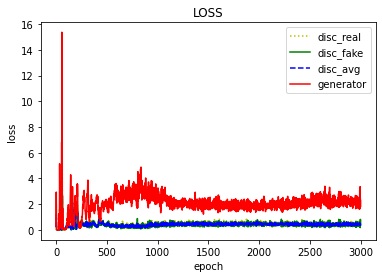

In [15]:
import numpy as np
import matplotlib.pyplot as plt
epo = np.arange(0, epoch)
plt.figure()
plt.plot(epo, loss_disc_real, 'y:', label='disc_real')
plt.plot(epo, loss_disc_fake, 'g-', label='disc_fake')
plt.plot(epo, loss_disc_avg, 'b--', label='disc_avg')
plt.plot(epo, loss_gan, 'r', label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 정확도 그래프

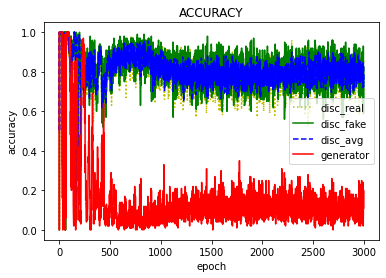

In [16]:
plt.figure()
plt.plot(epo, acc_disc_real, 'y:', label='disc_real')
plt.plot(epo, acc_disc_fake, 'g-', label='disc_fake')
plt.plot(epo, acc_disc_avg, 'b--', label='disc_avg')
plt.plot(epo, acc_gan, 'r', label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### GAN으로 생성된 가짜 손글씨 데이터 확인

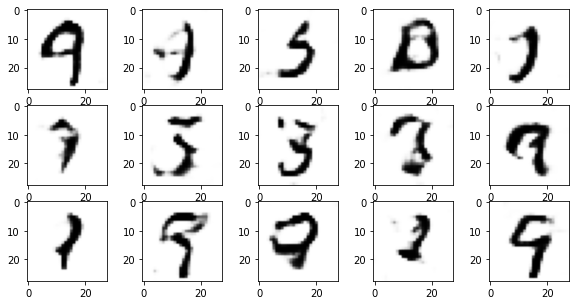

In [17]:
import matplotlib.pyplot as plt
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))
for i in range(3 * 5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')

plt.show()